# cFos Drug Notebook

## Setup

In [ ]:
# Import packages
import os, sys, importlib
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import glob

sys.path.append('functionScripts')
sys.path.append('dependencies')

import initFunctions as init #import createDirs, debugReport, loadLightSheetData
import analysisFunctions as af #compareAnimals, drug_stats_and_changes, brainRegionTrend
import classifyFunctions as cf #sclassifySamples, reformatData
import plotFunctions as pf #totalCountsPlot
import helperFunctions as hf
import configFunctions as config

### Switches

In [ ]:
## Switch to control whether Batch 1 and Batch 2 datasets are analyzed together. Distinct folders for each style.
batchSplit = False          # Splits drugs from the first batch of data, from the second, from the 3rd. Batch 1 is labeled with 'a' (aSAL, aKET, aPSI), Batch 3 (cKET, MDMA)
splitTag  = ['a', '', 'c']  # Appended the to beginning of data from the first batch (PSI, KET, SAL -> aPSI, KET, aSAL).

# Debug
debugOutputs = False        # Saves csvs at intervals
scalingFactor = True        # Applies 1/total_cells as a scaling factor for mice in batch one.
debug_ROI = ['Dorsal nucleus raphe']

### Configuration related dictionaries and function calls

In [ ]:
switchDir = dict(batchSplit=batchSplit, splitTag=splitTag, debugOutputs=debugOutputs, scalingFactor=scalingFactor, debug_ROI=debug_ROI)

# Make directories, and add their strings to the directory dictionary.
dirDict = init.setPath_createDirs()

# General Figure Settings
config.setup_figure_settings()

# Figure 2 related setup
heatmapDict = config.return_heatmapDict()

#### Figure 3, 4, 5, 6
# Configure the classification - testing for quicker results, default for final.
# classifyDict = config.return_classifyDict_testing()   # Test with this
classifyDict = config.return_classifyDict_default()     # Full run

# Plot dict, used to coordinate outputs of classification plotting.
plotDict = config.return_plotDict()

### Load/Generate Lightsheet df

In [ ]:
# once directories have been made, merge data across batches and with atlases, then save.
lightsheet_data = init.loadLightSheetData(dirDict, switchDir)

# Create the Drug list for reference. Sorting doesn't seem to matter atm.
drugList = list(lightsheet_data.drug.unique())
drugListActive = [x for x in drugList if 'SAL' not in x]

## Figure 1 - Head twitch response + Cell count per drug

In [ ]:
pf.plot_headTwitchTotal(dirDict)
pf.plotTotalPerDrug(lightsheet_data, 'total_cells', dirDict)

## Figure 2 - Data Heatmaps

In [ ]:
pf.plot_data_heatmap(lightsheet_data, heatmapDict, dirDict)

## Figure 3 - Drug Classifier

In [ ]:
### Figure 3b - Supervised Dim Red via LDA
ldaDict = dict()

pf.plotLowDimEmbed(lightsheet_data, 'count_norm', dirDict, 'LDA', classifyDict, ldaDict) # 'count_norm', 'total_cells','cell_density'

In [ ]:
ldaDict = dict()

# ldaDict['AnalysisName'] = [[Training Set], [Testing Set]]
ldaDict['LO_6FDET'] = [['5MEO', 'A-SSRI', 'C-SSRI', 'KET', 'MDMA', 'PSI', 'SAL'], drugList]

pf.plotLowDimEmbed(lightsheet_data, 'count_norm', dirDict, 'LDA', classifyDict, ldaDict) # 'count_norm', 'total_cells','cell_density'

In [ ]:
### Figure 3c/d - Drug based Confusion Matrix + PR Curves
# classifyDict['label'] = 'drug' - already done in config file

cf.classifySamples(lightsheet_data, classifyDict, plotDict, dirDict)

## Figure 4 - 'PSI vs' classification

### Run the classifications

In [ ]:
# Revise Plot dict below
plotDict['plot_ConfusionMatrix'] = True
plotDict['plot_PRcurve'] = True
plotDict['plot_SHAPsummary'] = False
plotDict['plot_SHAPforce'] = False
plotDict['featureCorralogram'] = False

classifyVec = ['class_Psi5MEO', 'class_PsiKet', 'class_PsiMDMA', 'class_PsiDF', 'class_PsiSSRI', 'class_DT', 'class_5HTR', 'class_5HT2A', 'class_SSRI']

for i in classifyVec:
    try:
        print(f"Classifying {i}")
        classifyDict['label'] = i
        cf.classifySamples(lightsheet_data, classifyDict, plotDict, dirDict)
    except Exception:
        print(f"\n Failed to classify {i}")

### SF. Classifications w/o 6-F-DET in training set

In [ ]:
plotDict['plot_ConfusionMatrix'] = True
plotDict['plot_PRcurve'] = False
plotDict['plot_SHAPsummary'] = False
plotDict['plot_SHAPforce'] = False
plotDict['featureCorralogram'] = False
classifyDict['saveLoadswitch'] = True
classifyDict['shuffle'] = False

classifyVec = ['LO_6FDET']

for i in classifyVec:
    try:
        print(f"Classifying {i}")
        classifyDict['label'] = i
        cf.classifySamples(lightsheet_data, classifyDict, plotDict, dirDict)
    except Exception:
        print(f"\n Failed to classify {i}")

### Figure setup

In [ ]:
importlib.reload(hf)
importlib.reload(config)
importlib.reload(pf)

# Figure Settings
config.setup_figure_settings()

filterByFreq = .75 * classifyDict['CV_count']

sortedNames = ['5MEO vs PSI', 'MDMA vs PSI', 'A-SSRI vs PSI', 'KET vs PSI', '6-F-DET vs PSI', '5MEO vs 6-F-DET', 'A-SSRI vs C-SSRI', 'PSI/5MEO vs MDMA', 'PSI/5MEO vs 6-F-DET']

sortedNames.reverse()

featureLists, comparisonNames, aucScores, meanScores, aucScrambleScores, meanScrambleScores = hf.retrieve_dict_data(dirDict, classifyDict)

sortIdx = hf.sort_comparison_idx(sortedNames, comparisonNames)

featureLists = [featureLists[i] for i in sortIdx]
comparisonNames = [comparisonNames[i] for i in sortIdx]
aucScores = [aucScores[i] for i in sortIdx]
meanScores = [meanScores[i] for i in sortIdx]
aucScrambleScores = [aucScrambleScores[i] for i in sortIdx]
meanScrambleScores = [meanScrambleScores[i] for i in sortIdx]

# Replace instances of '/' with ' & ' in the score names
comparisonNames = [score.replace('/', ' & ') for score in comparisonNames]

# For every scoreName containing 'PSI', slice the string by ' vs ', swap the order of the two strings, and join them back together
comparisonNames = [score.split(' vs ')[1] + ' vs ' + score.split(' vs ')[0] if 'PSI' in score else score for score in comparisonNames]

### Figure 4b - mean AUPRC across comparisons

In [ ]:
importlib.reload(pf)
pf.plot_cross_model_AUC(comparisonNames, aucScores, aucScrambleScores, dirDict)

### Figure 4c - Feature Violin plots

In [ ]:
pf.plot_featureCount_violin(comparisonNames, featureLists, dirDict)
# pf.plot_similarity_matrix(comparisonNames, featureLists, filterByFreq, dirDict)
# pf.plot_featureOverlap_VennDiagram(comparisonNames, featureLists, filterByFreq, dirDict)


### Figure 4d - Feature Heatmaps

In [ ]:
pf.plot_featureHeatMap(lightsheet_data, comparisonNames, featureLists, filterByFreq, dirDict)

## Figure 5 - PSI vs 5MEO SHAP analysis

In [ ]:
plotDict['plot_ConfusionMatrix'] = False
plotDict['plot_PRcurve'] = False
plotDict['plot_SHAPsummary'] = True
plotDict['plot_SHAPforce'] = True

classifyDict['label'] = 'class_Psi5MEO'

cf.classifySamples(lightsheet_data, classifyDict, plotDict, dirDict)

## Figure 6 - PSI vs KET, A-SSRI, and MDMA analysis

In [ ]:
# Revise Plot dict below
plotDict['plot_SHAPsummary'] = True
plotDict['plot_SHAPforce'] = False

classifyVec = ['class_PsiMDMA', 'class_PsiSSRI', 'class_PsiKet']

for i in classifyVec:
    try:
        print(f"Classifying {i}")
        classifyDict['label'] = i
        cf.classifySamples(lightsheet_data, classifyDict, plotDict, dirDict)
    except Exception:
        print(f"\n Failed to classify {i}")

## Supplemental Figure Generation

<Figure size 1920x1440 with 0 Axes>

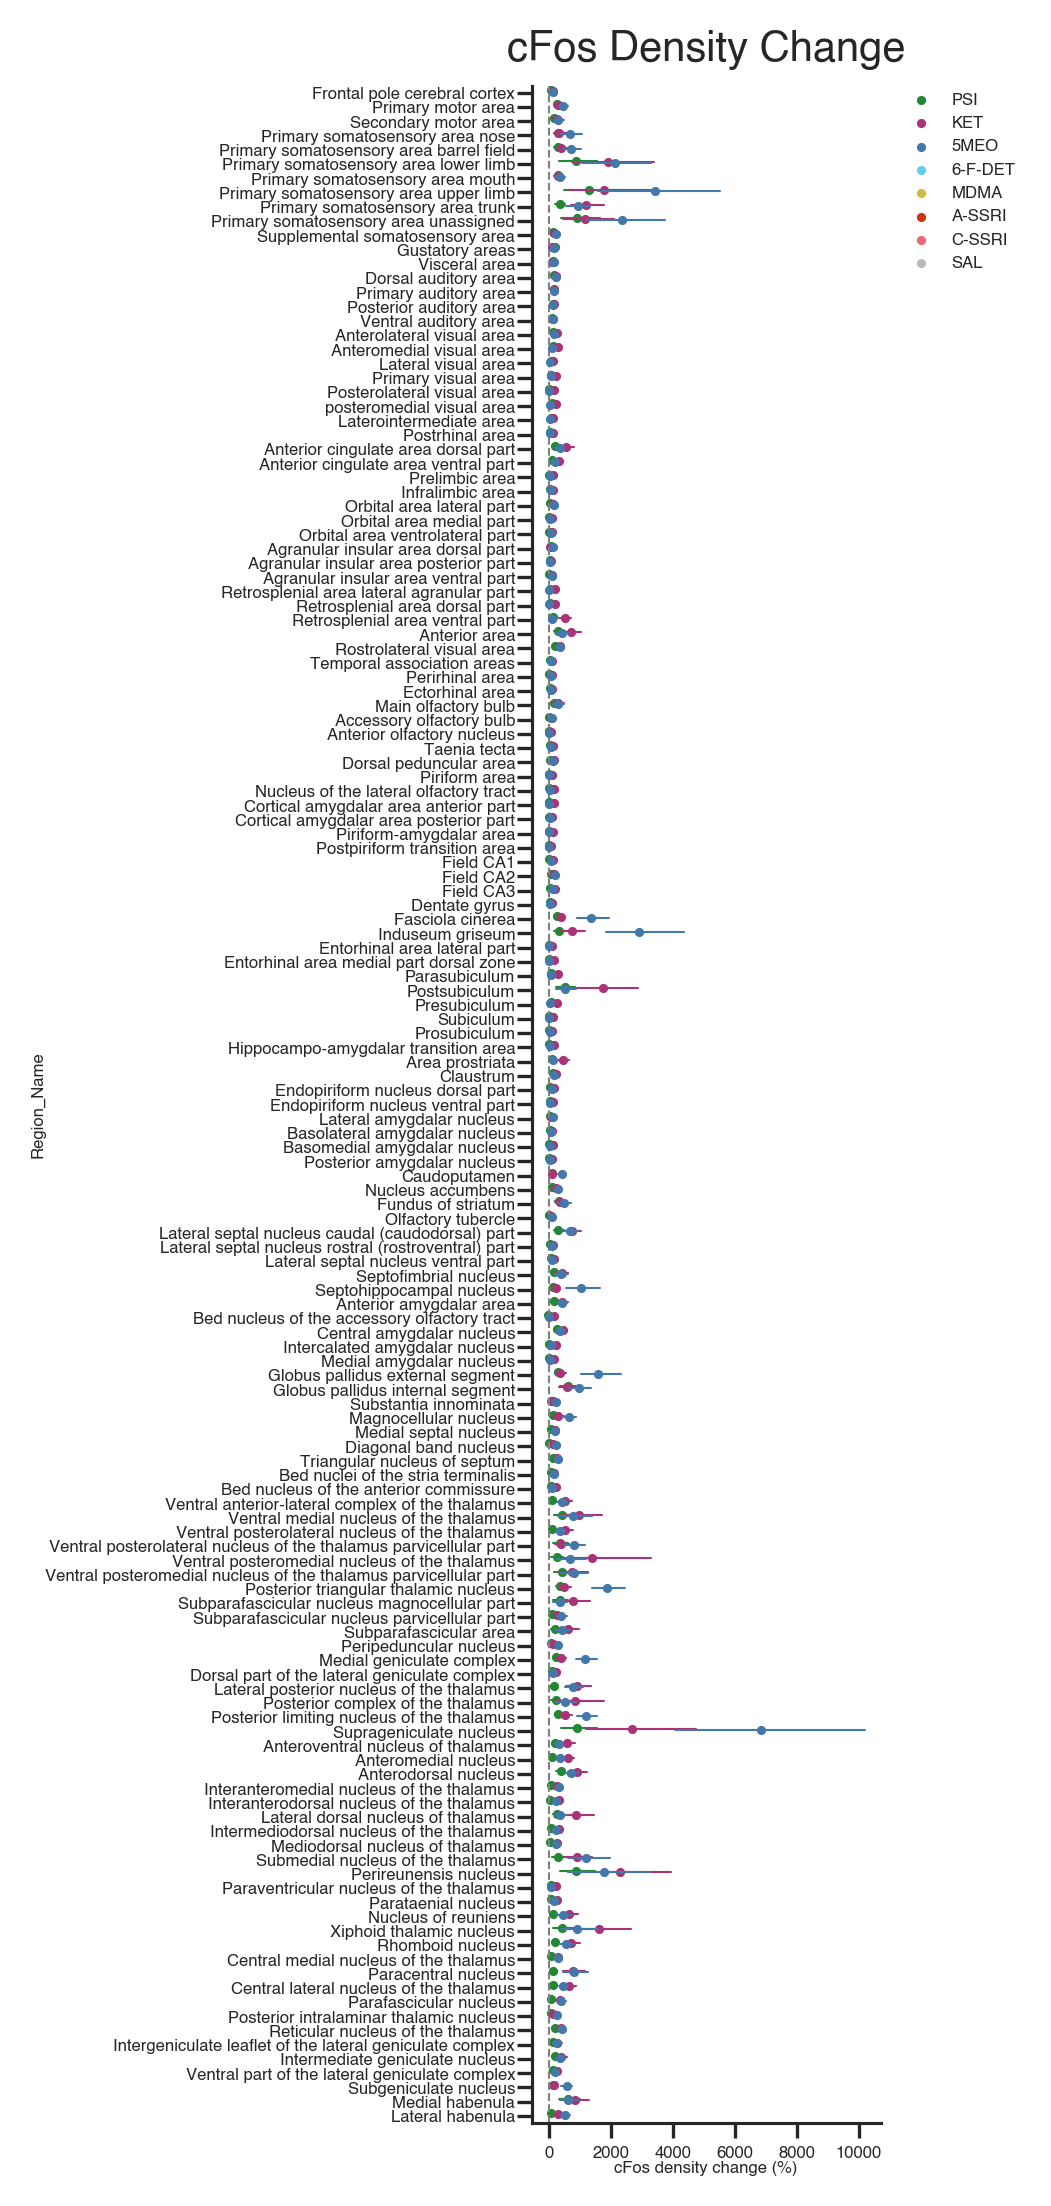

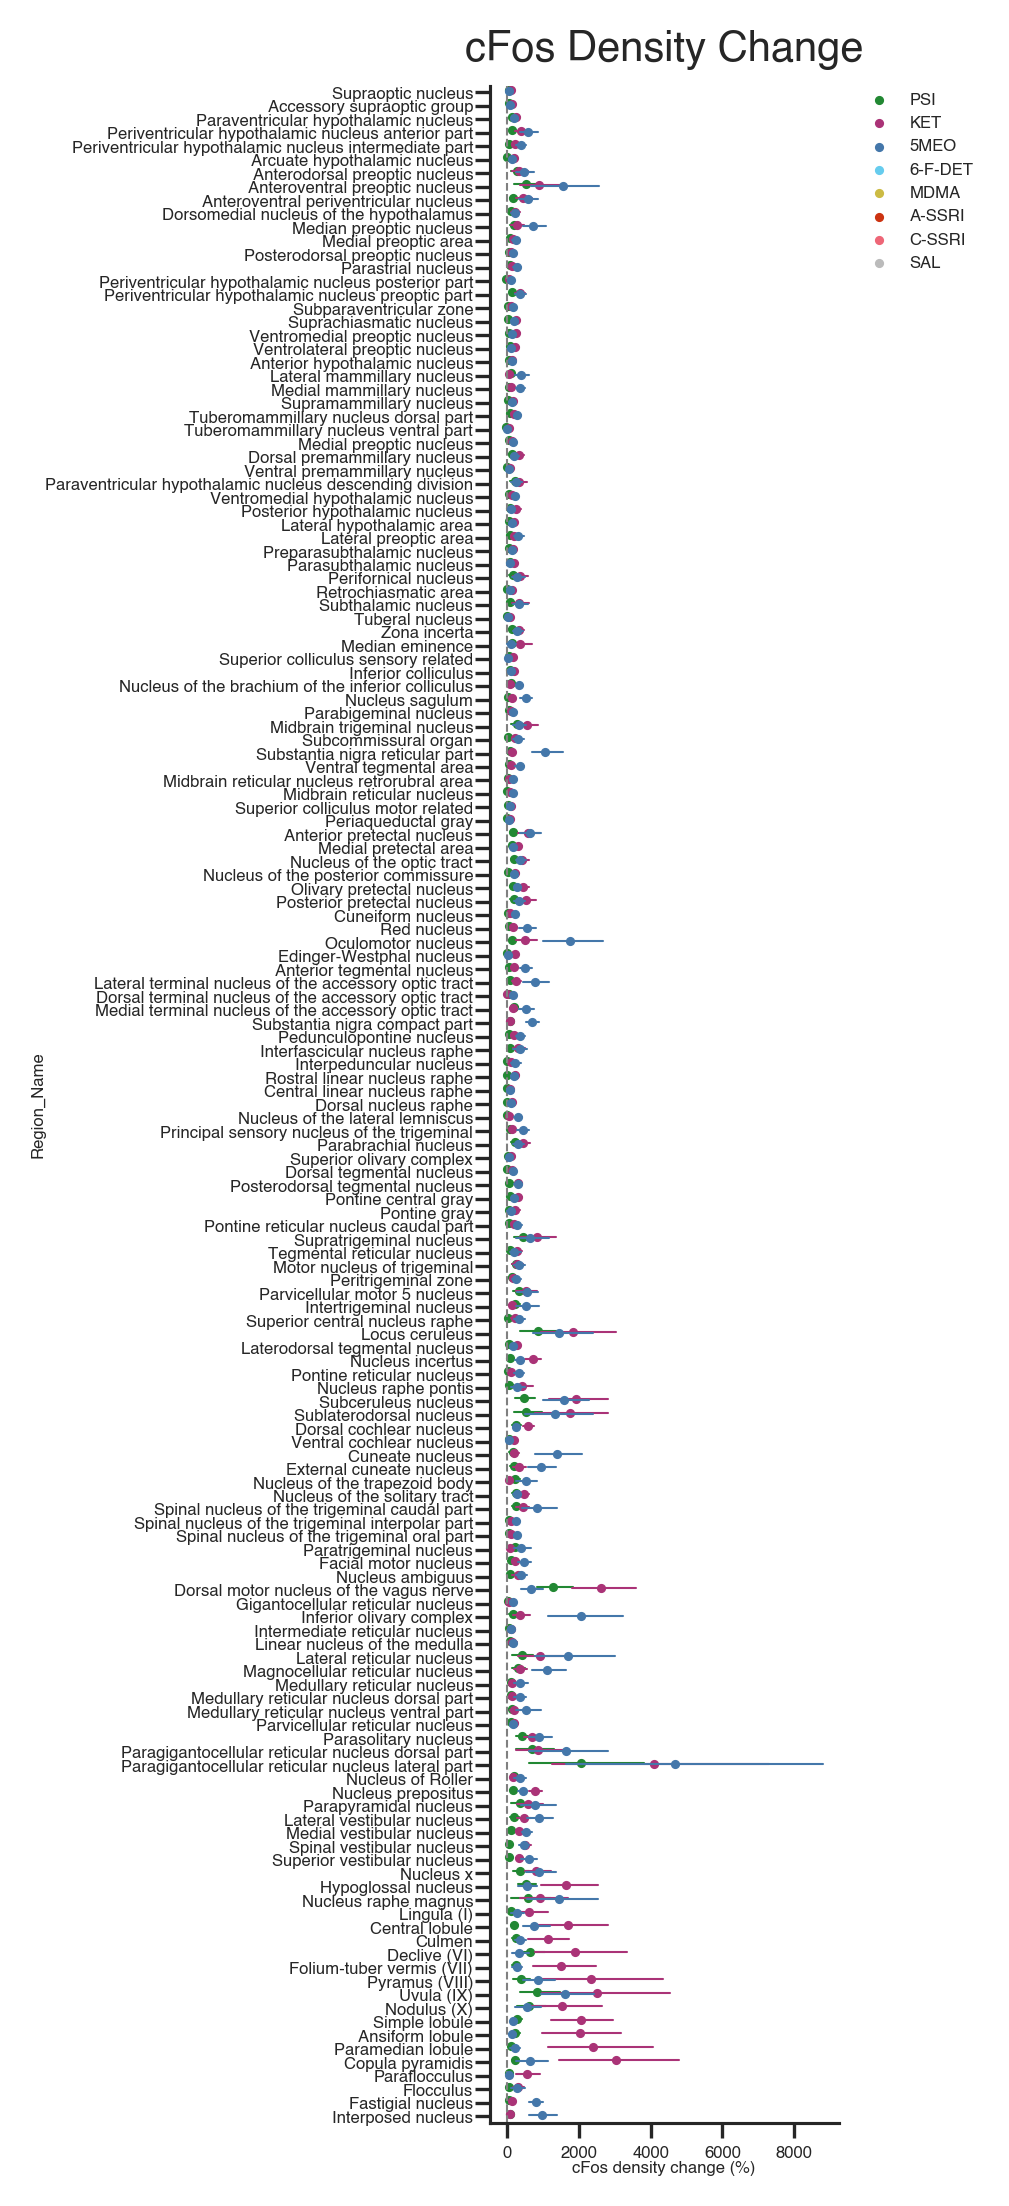

In [83]:
# Change figure settings for this large figure
config.setup_figure_changeFonts(6)
importlib.reload(pf)
importlib.reload(hf)
importlib.reload(config)

# Additional Processing - Generate Data structures for changes
cfos_diff, cfos_diff_labels = af.drug_stats_and_changes(lightsheet_data, drugList, True)[2:4]

config.setup_saldiff_settings()

# Plotting - if the plot hasn't already been generated
fileOutName = os.path.join(dirDict['outDir'], 'fig2_deltaPerRegion_SAL')
pf.plot_cFos_delta_new(lightsheet_data, cfos_diff, cfos_diff_labels, drugList, fileOutName)
# if len(glob.glob(fileOutName + '.*')) == 0:
#     pf.plot_cFos_delta(cfos_diff, drugList, fileOutName)

### mRNA + cFos correlations

In [ ]:
ABA_dict_filt = hf.create_ABA_dict(dirDict)

# get allen names
hierarchy_meso_ids = ABA_dict_filt.rename(columns={'Region ID':'Region_ID'})
ZscoreStructure = hf.generate_ZscoreStructure(hierarchy_meso_ids, dirDict)

#cFos
cfos_all = af.drug_stats_and_changes(lightsheet_data, drugList, True)[0]
cfos_all = cfos_all.merge(hierarchy_meso_ids, on='abbreviation')
cfos_all = cfos_all.rename(columns={'Region_ID_x':'Region_ID'})
cfos_all = cfos_all.drop(columns={'Region_ID_y'})

cfos_x_genes = cfos_all.merge(ZscoreStructure, on=['Region_ID','abbreviation','Brain Area'])
cfos_x_genes = cfos_x_genes.rename(columns={'Region_Name_x':'Region_Name'})

In [ ]:
importlib.reload(pf)
# Gene x structure correlation 
drugListActive = ['MDMA', '5MEO', '6-F-DET', 'A-SSRI', 'C-SSRI', 'KET', 'PSI']
# drugListActive = ['KET', 'PSI']
regionSet = ['Cortex']
geneDict, geneColorDict, setNames = config.cFos_mRNA_corr_settings()
plotNameDict = hf.create_translation_dict(dictType='drug')

# Generates files and saves them in tempdir
af.gen_gene_corr(cfos_x_genes, splitTag, drugListActive, regionSet, dirDict) 

# Use the data generated above to plot.
pf.genereate_cFos_gene_corr_plots(geneDict, geneColorDict, setNames, regionSet, plotNameDict, dirDict)